In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.measure

In [10]:
path_root = "/home/arnab/MEGAsync/Research/Attention Tracking/Eye Tracking/Data_Backup/saved_sessions_latest/"

In [5]:
with open("session_track.json", 'r') as f:
    session_track = json.load(f)
session_track

{'template': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': '',
   'Position 2': '',
   'Position 3': '',
   'Position 4': '',
   'Position 5': '',
   'Position 6': '',
   'Position 7': '',
   'Position 8': '',
   'Position 9': '',
   'Right': '',
   'Left': '',
   'Up': '',
   'Down': '',
   'Blink': ''}},
 'P0': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': 'session_2021-09-24T10:09:59.226067.json',
   'Position 2': 'session_2021-09-24T10:10:40.966059.json',
   'Position 3': 'session_2021-09-24T10:11:12.264553.json',
   'Position 4': 'session_2021-09-24T10:11:40.039892.json',
   'Position 5': 'session_2021-09-24T10:12:05.820481.json',
   'Right': 'session_2021-09-24T10:13:07.759221.json',
   'Left': 'session_2021-09-24T10:13:32.368622.json',
   'Up': 'session_2021-09-24T10:13:59.251024.json',
   

In [24]:
def getSecondFromTimeStamp(timestamp):
    return timestamp["hour"]*60*60 + timestamp["minute"]*60 + timestamp["seconds"]


def gaze__processOneSession(gaze_arr, latest = None):
    xrr = []
    yrr = []
    if(latest != None and len(gaze_arr) > 0):
        endtime = getSecondFromTimeStamp(gaze_arr[-1]["timestamp"])
    for gaze in gaze_arr:
        if(latest != None):
            curr_time = getSecondFromTimeStamp(gaze["timestamp"])
            if(endtime - curr_time > latest):
                continue
        xrr.append(gaze["gaze"]["x"])
        yrr.append(gaze["gaze"]["y"])
    return np.array(xrr), np.array(yrr)


def loadjson_singleSession(session_name):
    session_name = session_name.replace(":", "%3a")
    folder = session_name.split('.json')[0]
    with open(path_root + folder + "/" + session_name, 'r') as f:
        session = json.load(f)
        if(len(session.keys()) != 1):
            print("{} session has {} ids".format(session_name, len(session.keys())))
        ret_session = []
        ret_len = 0
        for id in session:
            if(len(session[id]) > ret_len):
                ret_len = len(session[id])
                ret_session = session[id]
        return ret_session


def calculate_MSE(xrr, yrr, marker_x, marker_y):
    ret = 0
    for idx in range(xrr.shape[0]):
        ret += (marker_x - xrr[idx])**2 + (marker_y - yrr[idx])**2
    return ret/xrr.shape[0]

In [16]:
not_valid = ["template", "P0", "P0_", "P17"]

def loadjson__multileSession(position_filters, time_limit = 15, _filter = {"glass": -1, "gender": -1, "brightness": -1, "camera_res": -1}):
    combined_xrr = np.array([])
    combined_yrr = np.array([])
    individual_mse = []
    counter = 0

    if(type(position_filters) != list):
        position_filters = [position_filters]
    
    for position_key in position_filters:
        for participant in session_track:
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"])
            if participant in not_valid:
                continue
            # if glass != -1 and session_track[participant]["glass"] != glass:
            #     continue
            skip = False
            for key in _filter:
                if(key != "camera_res"):
                    val = session_track[participant][key]
                else:
                    val = session_track[participant]["camera_res"]["mega_pixels"]
                    if(val == -1):
                        skip = True
                        break
                    val = round(val, 1)
                    
                # print(key, " >> ", _filter[key], " <><> ", val)
                if(_filter[key] != -1 and val != _filter[key]):
                    skip = True
                    break

            if(skip):
                continue
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"], end=" <> ")
            
            json_session = loadjson_singleSession(session_track[participant]['sessions'][position_key])
            xrr, yrr = gaze__processOneSession(json_session, time_limit)
            # print("Shape: ", xrr.shape, yrr.shape)
            if(len(xrr) > 0):
                individual_mse.append(calculate_MSE(xrr, yrr, marker_track[position_key][0], marker_track[position_key][1]))
            else:
                continue
            combined_xrr = np.concatenate((combined_xrr, xrr))
            combined_yrr = np.concatenate((combined_yrr, yrr))
            counter += 1
     
    print("Found {} participants >> Combined shape".format(counter), combined_xrr.shape, combined_yrr.shape)
    return combined_xrr, combined_yrr, individual_mse, counter

In [17]:
session_name = "session_2021-09-24T10:09:59.226067/session_2021-09-24T10:09:59.226067.json"
session_name = session_name.replace(":", "%3a")
with open(path_root + session_name, 'r') as f:
    session = json.load(f)

In [18]:
xrr, yrr = gaze__processOneSession(session['hdehheeafrlqlylodn58si'], 10)
xrr.shape, yrr.shape

((124,), (124,))

In [19]:
accuracy_cords = [
    {'x': 50, 'y': 50},
    {'x': 10, 'y': 10},
    {'x': 10, 'y': 50},
    {'x': 10, 'y': 90},
    {'x': 50, 'y': 10},
    {'x': 50, 'y': 90},
    {'x': 90, 'y': 10},
    {'x': 90, 'y': 50},
    {'x': 90, 'y': 90},
]

marker_track = {}
for i in range(len(accuracy_cords)):
    marker_track["Position {}".format(i+1)] = [accuracy_cords[i]['x']/100, accuracy_cords[i]['y']/100]

print(len(marker_track.keys()))
marker_track

9


{'Position 1': [0.5, 0.5],
 'Position 2': [0.1, 0.1],
 'Position 3': [0.1, 0.5],
 'Position 4': [0.1, 0.9],
 'Position 5': [0.5, 0.1],
 'Position 6': [0.5, 0.9],
 'Position 7': [0.9, 0.1],
 'Position 8': [0.9, 0.5],
 'Position 9': [0.9, 0.9]}

In [51]:
def plotHeatmap(xrr, yrr, subplot):
    heat_map = np.zeros((1001, 1001))
    for idx in range(xrr.shape[0]):
        xx = int(round(xrr[idx]*1000))
        xx = max(xx, 0)
        xx = min(xx, 1000)

        yy = int(round(yrr[idx]*1000))
        yy = max(yy, 0)
        yy = min(yy, 1000)
        try:
            heat_map[yy, xx] += 1
        except:
            print(f"{yy}({yrr[idx]}), {xx}({xrr[idx]})")
            # return
    print("heatmap shape", heat_map.shape)
    heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
    print(heatmap_reduced.shape, heatmap_reduced.min(), heatmap_reduced.max())
    subplot.pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                    shading='gouraud', 
                    vmin=heatmap_reduced.min(), 
                    vmax=heatmap_reduced.max())
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.invert_yaxis()

In [67]:
position = "Position 9"
xrr, yrr, ind_mse, counter = loadjson__multileSession(position)

session_2021-10-02T10%3a16%3a34.642542.json session has 2 ids
session_2021-10-04T02%3a40%3a07.729511.json session has 2 ids
Found 31 participants >> Combined shape (6184,) (6184,)


heatmap shape (1001, 1001)
(11, 11) 0.0 0.0335


/home/arnab/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


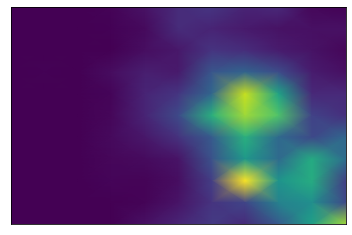

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plotHeatmap(xrr, yrr, ax)
fig.show()

In [69]:
len(xrr)

6184